# Проект 4. Авиарейсы без потерь, работа с БД

* Гиль Юлия
* Группа DSPR-28

**ЗАДАЧА**

Необходимо выяснить, от каких самых малоприбыльных рейсов из Анапы можем отказаться в зимнее время. Вы не знаете, по каким критериям ваше руководство будет отбирать рейсы, поэтому решаете собрать как можно больше информации, содержащейся в вашей базе, в один датасет. 

Исходя из того, что прибыльность рейса — это разница между доходом от продаж билетов и расходом на полет, соберите такой датасет, который позволит оценить эти цифры. 

# Table of Contents

1. [IMPORT](#1)
2. [DATA](#2)
3. [CLEANING AND PREPARING DATA](#3)
    * [Обработка NAN ](#3.1)
    * [Анализ и генерация новых признаков](#3.2)
8. [SUMMARY](#4)



<a id="1"></a>
# 1. IMPORT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import random
import pandas_profiling

import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set()

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

<a id="2"></a>
# 2. DATA

In [2]:
# Открываем необходимые данные, создаем датафреймы
flight = pd.read_csv('flights_data.csv')
craft_ext = pd.read_csv('external_data.csv')

In [3]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            193 non-null    int64  
 1   flight_no            193 non-null    object 
 2   departure_airport    193 non-null    object 
 3   arrival_airport      193 non-null    object 
 4   month_2017           193 non-null    float64
 5   flight_time          193 non-null    object 
 6   flight_dow           193 non-null    int64  
 7   flight_duration_min  193 non-null    float64
 8   flight_delay_min     193 non-null    float64
 9   model                193 non-null    object 
 10  seats_count          193 non-null    int64  
 11  passenger_count      180 non-null    float64
 12  occupancy            180 non-null    float64
 13  flight_income        180 non-null    float64
dtypes: float64(6), int64(3), object(5)
memory usage: 21.2+ KB


In [4]:
flight.sample(5)

,flight_id,flight_no,departure_airport,arrival_airport,month_2017,flight_time,flight_dow,flight_duration_min,flight_delay_min,model,seats_count,passenger_count,occupancy,flight_income
191,136755,PG0480,AAQ,EGO,1.0,09:25,7,50.0,5.0,Sukhoi Superjet-100,97,97.0,1.000000,765300.0
171,136769,PG0480,AAQ,EGO,2.0,09:25,6,50.0,6.0,Sukhoi Superjet-100,97,88.0,0.907216,696000.0
72,136387,PG0252,AAQ,SVO,1.0,10:05,5,100.0,2.0,Boeing 737-300,130,121.0,0.930769,1775000.0
55,136366,PG0252,AAQ,SVO,1.0,10:05,4,100.0,2.0,Boeing 737-300,130,103.0,0.792308,1527400.0
61,136132,PG0252,AAQ,SVO,2.0,10:05,4,100.0,3.0,Boeing 737-300,130,116.0,0.892308,1714000.0


In [5]:
craft_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   model                       2 non-null      object 
 1   fuel_cost_dec_2016_rub_ton  2 non-null      int64  
 2   fuel_cost_jan_2017_rub_ton  2 non-null      int64  
 3   fuel_cost_feb_2017_rub_ton  2 non-null      int64  
 4   fuel_cons_kg_hr             2 non-null      int64  
 5   fuel_cons_g_km              2 non-null      float64
dtypes: float64(1), int64(4), object(1)
memory usage: 224.0+ bytes


In [6]:
craft_ext.head()

,model,fuel_cost_dec_2016_rub_ton,fuel_cost_jan_2017_rub_ton,fuel_cost_feb_2017_rub_ton,fuel_cons_kg_hr,fuel_cons_g_km
0,Boeing 737-300,38867,41435,39553,2600,22.5
1,Sukhoi Superjet-100,38867,41435,39553,1700,21.1


Подробнее по признакам.

Датасет с данными полета:
* 'fligh_id' — id рейса,
* 'flight_no' — номера рейса, 
* 'departure_airport' — аэропорты вылета, 
* 'arrival_airport' — аэропорты прибытия, 
* 'month_2017' — месяц отчетного периода (12, 1, 2),
* 'flight_time' — время вылета самолета (чч:мм), 
* 'flight_dow' — день недели вылета самолета (1—7, где 1— пн, 2 — вт и тд), 
* 'flight_duration_min' — запланированная длительность полета (мин), 
* 'flight_delay_min' — задержка рейса (мин),
* 'model' — название модели самолета, 
* 'seats_count' — количечство мест в моделе самолета, 
* 'passenger_count' — количество пассажиров на рейсе (чел),
* 'occupancy' — реальноя заполняемость самолета (актуальное число пассажиров/количество мест), 
* 'flight_income' — стоимость всех проданных мест рейса.

Датасет с внешними данными:
* 'aircraft_model' — название модели самолета, 
* 'fuel_cost_dec_2016_rub_ton' — стоимость топлива в декабре 2016,
* 'fuel_cost_jan_2017_rub_ton' — стоимость топлива в январе 2017, 
* 'fuel_cost_feb_2017_rub_ton' — стоимость топлива в феврале 2017,
* 'fuel_cons_kg_hr' — часовой расход топлива (кг/ч), 
* 'fuel_cons_g_km'— удельный расход топлива (г/км).

<a id="3"></a>
# 3. CLEANING AND PREPARING DATA

<a id="3.1"></a>
## 3.1. Обработка NAN 

Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [7]:
def intitial_eda_checks(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также проце
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:\n \n')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

In [8]:
# Запускаем функцию вывода всех пустых значений
intitial_eda_checks(flight, 0)

Сумма и процент значений NaN:
 



,Количество,%
flight_income,13,6.74
occupancy,13,6.74
passenger_count,13,6.74


<AxesSubplot:>

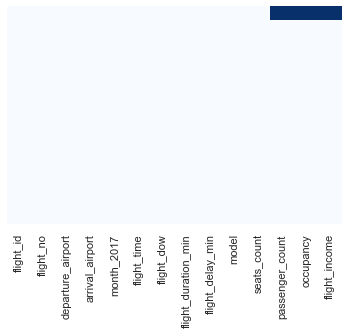

In [9]:
# Посмотрим, как распределены пропуски
sns.heatmap(flight.isnull(), yticklabels=False, cbar=False, cmap='Blues')

Признаки пропущены для 13 рейсов. Выведем на экран все эти рейсы.

In [10]:
flight[(flight.flight_income.isnull() == True)]

,flight_id,flight_no,departure_airport,arrival_airport,month_2017,flight_time,flight_dow,flight_duration_min,flight_delay_min,model,seats_count,passenger_count,occupancy,flight_income
0,136567,PG0194,AAQ,NOZ,2.0,06:10,3,305.0,8.0,Boeing 737-300,130,NaN,NaN,NaN
1,136513,PG0194,AAQ,NOZ,2.0,06:10,3,305.0,8.0,Boeing 737-300,130,NaN,NaN,NaN
2,136514,PG0194,AAQ,NOZ,2.0,06:10,3,305.0,-2.0,Boeing 737-300,130,NaN,NaN,NaN
3,136560,PG0194,AAQ,NOZ,1.0,06:10,3,305.0,3.0,Boeing 737-300,130,NaN,NaN,NaN
4,136544,PG0194,AAQ,NOZ,1.0,06:10,3,305.0,-1.0,Boeing 737-300,130,NaN,NaN,NaN
5,136511,PG0194,AAQ,NOZ,2.0,06:10,3,305.0,10.0,Boeing 737-300,130,NaN,NaN,NaN
6,136540,PG0194,AAQ,NOZ,1.0,06:10,3,305.0,6.0,Boeing 737-300,130,NaN,NaN,NaN
7,136533,PG0194,AAQ,NOZ,12.0,06:10,3,305.0,1.0,Boeing 737-300,130,NaN,NaN,NaN
8,136564,PG0194,AAQ,NOZ,12.0,06:10,3,305.0,6.0,Boeing 737-300,130,NaN,NaN,NaN
9,136546,PG0194,AAQ,NOZ,1.0,06:10,3,305.0,0.0,Boeing 737-300,130,NaN,NaN,NaN


Как видим, это все рейсы с номером PG0194. 
Проверила дополнительно базу: по другим месяцам также нулевая заполняемость и доходность.
Стратегия заполнения пропуско: заполняем нулями.

In [11]:
# Заполняем нулями пропуски
flight.fillna(0, inplace=True)
intitial_eda_checks(flight, 0)

NaN значения не найдены.


<a id="3.2"></a>
## 3.2. Анализ и генерация новых признаков

#### 3.2.1 Чистка данных

In [12]:
# Для удобства признак дохода рейса поделим на 1000 и будем выводить в тыс. руб.
flight['flight_income'] = flight['flight_income'].apply(lambda x: x/1000)

In [13]:
# Идея заменить дни недели на сокращения, но некорректная сортировка на графиках. Пока закоментирую.
#weekdays_dict = {1: "1_Sun", 2: "2_Mon", 3: "3_Tue", 4: "4_Wed", 5: "5_Thur", 6: "6_Fri", 7: "7_Sat"}
# flight['flight_dow'].replace(
# to_replace=weekdays_dict, inplace=True)  # заменяем значения в соответствии со словарем

#### 3.2.2 Анализ признаков, поиск выбросов.

##### Датасет

Посмотрим на данные в целом.

In [14]:
def print_flight_info(df):
    """
    Функция на вход принимает датафрейм с данными о направлениях перелетов.
    Печатает основную информацию по данным.
    """
    for i in df.flight_no.unique():
        print('Номер рейса:', i)
        df_fligh = df[df['flight_no'] == i].copy()
        print(
            f"Совершает рейсы из аэропорта {df_fligh['departure_airport'].unique()} в аэропорт {df_fligh['arrival_airport'].unique()}")
        print('Совершенных рейсов:', len(df_fligh['flight_no']))
        print(
            f"Время вылета: {df_fligh['flight_time'].unique()}, по дням недели: {df_fligh['flight_dow'].unique()}")
        print('Модель самолета:', df_fligh['model'].unique())
        print(' ')
        print('Количество перевезенных пассажиров, чел:',
              df_fligh['passenger_count'].sum())
        print('Средняя заполняемость рейсов, %:',
              round(df_fligh['occupancy'].mean()*100))
        print(' ')
        print('Среднее время полета, мин:',
              df_fligh['flight_duration_min'].mean())
        print('Среднее время задержек прилета, мин:',
              round(df_fligh['flight_delay_min'].mean(), 2))
        print(' ')
        print('Доход за отчетный период, тыс. руб:',
              round(df_fligh['flight_income'].sum(), 2))
        print(' ')
        print('*********************************************')
        print(' ')

In [15]:
# Посмотрим на данные, которые попали в датафрейм
print_flight_info(flight)

Номер рейса: PG0194
Совершает рейсы из аэропорта ['AAQ'] в аэропорт ['NOZ']
Совершенных рейсов: 13
Время вылета: ['06:10'], по дням недели: [3]
Модель самолета: ['Boeing 737-300']
 
Количество перевезенных пассажиров, чел: 0.0
Средняя заполняемость рейсов, %: 0
 
Среднее время полета, мин: 305.0
Среднее время задержек прилета, мин: 4.15
 
Доход за отчетный период, тыс. руб: 0.0
 
*********************************************
 
Номер рейса: PG0252
Совершает рейсы из аэропорта ['AAQ'] в аэропорт ['SVO']
Совершенных рейсов: 90
Время вылета: ['10:05'], по дням недели: [1 2 3 4 5 6 7]
Модель самолета: ['Boeing 737-300']
 
Количество перевезенных пассажиров, чел: 10210.0
Средняя заполняемость рейсов, %: 87
 
Среднее время полета, мин: 100.0
Среднее время задержек прилета, мин: 5.06
 
Доход за отчетный период, тыс. руб: 148220.8
 
*********************************************
 
Номер рейса: PG0480
Совершает рейсы из аэропорта ['AAQ'] в аэропорт ['EGO']
Совершенных рейсов: 90
Время вылета: ['0

##### Признак flight_delay_min
Поскольку данный признак будет участвовать в расчете прибыльности, посмотрим на его распределение и наличие выбросов.

count    193.000000
mean       7.005181
std       27.935099
min       -2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max      220.000000
Name: flight_delay_min, dtype: float64

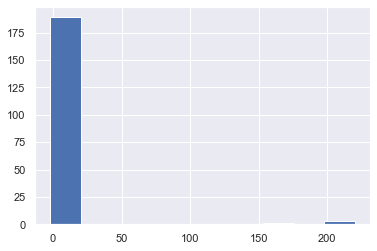

In [16]:
# Посмотрим на распредление признака
flight['flight_delay_min'].hist()
flight['flight_delay_min'].describe()

In [17]:
def iqr_analysis(series, mode=False):
    """
    Функция выводит инфорамцию о границах выборосов для признака.
    Если mode = True, возвращается верхняя и нижняя границы выбросов.
    """
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

In [18]:
# Используем функцию для расчета границ выбросов для данных
iqr_analysis(flight['flight_delay_min'])

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


In [19]:
# Посмотрим на выбросы по задержкам рейсов, эмпирически выбрано число 11, которое чуть выше, чем верхняя граница выбросов
flight[flight['flight_delay_min'] > 11]

,flight_id,flight_no,departure_airport,arrival_airport,month_2017,flight_time,flight_dow,flight_duration_min,flight_delay_min,model,seats_count,passenger_count,occupancy,flight_income
40,136345,PG0252,AAQ,SVO,1.0,10:05,3,100.0,207.0,Boeing 737-300,130,108.0,0.830769,1517.6
119,136911,PG0480,AAQ,EGO,12.0,09:25,2,50.0,220.0,Sukhoi Superjet-100,97,87.0,0.896907,676.5
142,136855,PG0480,AAQ,EGO,1.0,09:25,4,50.0,162.0,Sukhoi Superjet-100,97,87.0,0.896907,702.3
186,136632,PG0480,AAQ,EGO,1.0,09:25,7,50.0,198.0,Sukhoi Superjet-100,97,91.0,0.938144,714.3


Стратегия работы с выбросами:
* Рейсов со значительными задержками полета всего 4. 
* Время задержки в 2-4 раза превышает время полета, что значительно скажется на прибыльности.
* Заменим значение для данных рейсов на среднее, т.к. предполагаем, что самолет находился не в движении, а в режиме ожидания разрешения на взлет.

In [20]:
# Заменяем выбросы на среднее
flight['flight_delay_min'] = flight['flight_delay_min'].apply(
    lambda x: flight['flight_delay_min'].mean() if x >= 11 else x)

count    193.000000
mean       3.051948
std        2.202847
min       -2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Name: flight_delay_min, dtype: float64

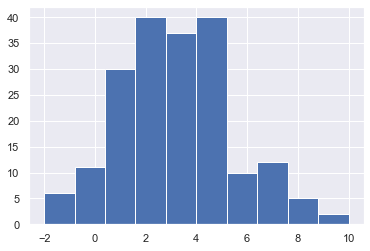

In [21]:
# Посмотрим, как изменилось распредлеение признака
flight['flight_delay_min'].hist()
flight['flight_delay_min'].describe()

##### Признак occupancy
Поскольку данный признак напрямую влияет на доходность рейса, посмотрим на его распределение и наличие выбросов.

count    193.000000
mean       0.841794
std        0.239974
min        0.000000
25%        0.823077
50%        0.900000
75%        0.984615
max        1.000000
Name: occupancy, dtype: float64

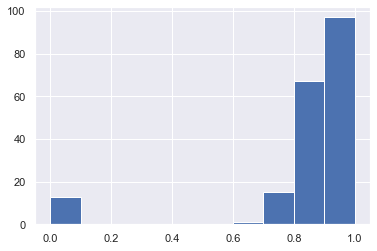

In [22]:
# Посмотрим на распределение признака
flight['occupancy'].hist()
flight['occupancy'].describe()

In [23]:
def show_values_on_bars(axs):
    """
    Функция позволяет отрисовать значения на графиках.
    """
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() * 1.1
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

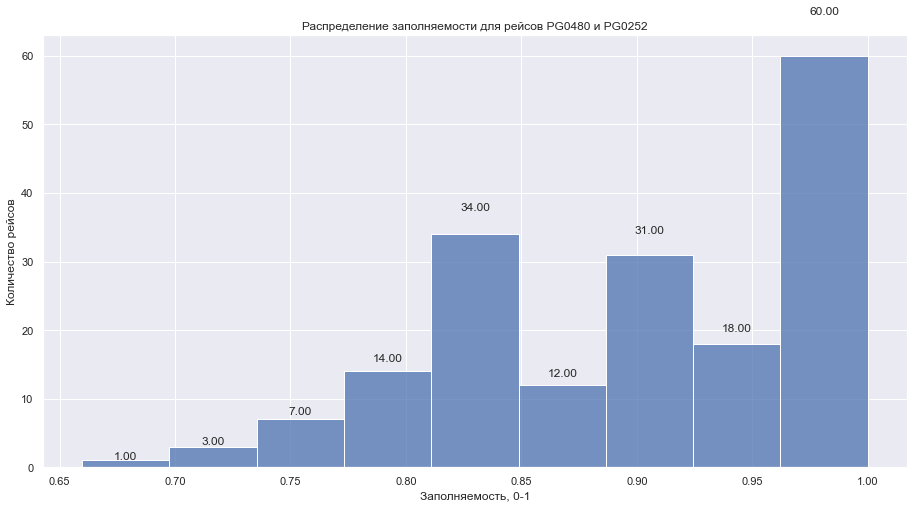

In [24]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 1.5])
sns.histplot(data=flight[flight.flight_no != 'PG0194'],
             x="occupancy", palette="Paired")
# Добавим поясняющие подписи
axes.set_xlabel('Заполняемость, 0-1')
axes.set_ylabel('Количество рейсов')
axes.set_title('Распределение заполняемости для рейсов PG0480 и PG0252')
show_values_on_bars(axes)

Признак не распределен нормально, но в пределах допустимых значений от 0 до 1. Выбросов явных нет.

Поисследуем, какие рейсы относятся к первому перцентилю, т.е. меньше (25% - 0.823077). Посмотрим, какие рейсы и в каком количестве хуже всего заполняются.

In [25]:
# Посмотрим, сколько рейсов с ненулевой заполненостью, но <82%
print('Количество рейсов, заполняемость которых хуже всего (Q1):', flight[(flight['occupancy'] < 0.823077) &
                                                                          (flight['occupancy'] > 0)]['flight_id'].count())

Количество рейсов, заполняемость которых хуже всего (Q1): 37


In [26]:
# Посмотрим, какие рейсы хуже всего заполняются из расписания за весь отчетный период
occupancy_low = flight[(flight['occupancy'] < 0.82) &
                       (flight['occupancy'] > 0)].groupby(['flight_no', 'flight_dow'])[
    'flight_id'].agg(['count'])

occupancy_low['percent'] = occupancy_low['count'].apply(
    lambda x: round(x/flight['flight_id'].count()*100, 2))

occupancy_low

count  percent
flight_no flight_dow                
PG0252    1               8     4.15
          2               2     1.04
          3               1     0.52
          4               5     2.59
          5               2     1.04
          6               1     0.52
          7               4     2.07
PG0480    1               2     1.04
          2               1     0.52
          3               2     1.04
          5               1     0.52
          6               2     1.04
          7               1     0.52

In [27]:
# Посмотрим, какие рейсы хуже всего заполняются из расписания с разбивкой по месяцам
occupancy_low = flight[(flight['occupancy'] < 0.82) &
                       (flight['occupancy'] > 0)].groupby(['flight_no', 'month_2017', 'flight_dow'])[
    'flight_id'].agg(['count'])

occupancy_low['percent'] = occupancy_low['count'].apply(
    lambda x: round(x/flight['flight_id'].count()*100, 2))

occupancy_low

count  percent
flight_no month_2017 flight_dow                
PG0252    1.0        1               3     1.55
                     2               2     1.04
                     4               2     1.04
                     5               1     0.52
                     6               1     0.52
                     7               1     0.52
          2.0        1               3     1.55
                     4               1     0.52
          12.0       1               2     1.04
                     3               1     0.52
                     4               2     1.04
                     5               1     0.52
                     7               3     1.55
PG0480    1.0        2               1     0.52
                     6               1     0.52
          2.0        1               1     0.52
                     3               2     1.04
                     5               1     0.52
                     6               1     0.52
                     7               1     0.52
          12.0       1               1     0.52

#### 3.2.2 Генерация новых признаков

Создадим признаки, которые позволяют посчитать прибыль каждого рейса.

##### Добавление внешних данных для рачета прибыли рейсов

Для детального расчета прибыльности рейсов необходимо учитывать большое количество статей расходов. На себестоимость перевозок существенно влияют стоимостные показатели:
* цена авиатоплива;
* стоимость владения воздушными судами; ставки заработной платы и численность персонала;
* затраты на техническое обслуживание и ремонты (T(DnP) авиационной техники;
* ставки сборов и тарифы в аэропортах, ставки сборов за аэронавигационное и метеообслуживание;
* затраты на обслуживание пассажиров, затраты на продажи перевозок, страхование, рекламу и т.д.

В нашем случае воспользуемся упрощенной моделью расчета прибыльности рейса, используя формулу:

**прибыльность =  стоимость билетов - стоимость топлива на рейс** 

Для оценки последнего необходим километраж рейса или длительность полета). Будем использовать длительность полета для расчета.
Посмотрим, какие модели самолетов используются в базе.

Данные взяты из источников:
- http://superjet.wikidot.com/wiki:rashod-topliva 
- https://www.airlines-inform.ru/commercial-aircraft/boeing-737-300.html 

In [28]:
# Посмотрим, какие модели самолетов используются в рейсах из базы
flight.model.unique()

array(['Boeing 737-300', 'Sukhoi Superjet-100'], dtype=object)

Из внеших источников нашла данные:

* 'fuel_cost_dec_2016_rub_ton' - стоиомость топлива в декабре 2016,
* 'fuel_cost_jan_2017_rub_ton' - - стоиомость топлива в январе 2017,
* 'fuel_cost_feb_2017_rub_ton' - - стоиомость топлива в феврале 2017,
* 'fuel_cons_kg_hr' - часовой расход топлива (кг/ч),
* 'fuel_cons_g_km'- удельный расход топлива (г/км).

In [29]:
# Добавляем внешний датасет в исходному.
flight = pd.merge(flight, craft_ext, on="model",
                  how="left")  # объединяем по aircraft_code

In [30]:
flight.sample(2)

,flight_id,flight_no,departure_airport,arrival_airport,month_2017,flight_time,flight_dow,flight_duration_min,flight_delay_min,model,seats_count,passenger_count,occupancy,flight_income,fuel_cost_dec_2016_rub_ton,fuel_cost_jan_2017_rub_ton,fuel_cost_feb_2017_rub_ton,fuel_cons_kg_hr,fuel_cons_g_km
186,136632,PG0480,AAQ,EGO,1.0,09:25,7,50.0,7.005181,Sukhoi Superjet-100,97,91.0,0.938144,714.3,38867,41435,39553,1700,21.1
59,136159,PG0252,AAQ,SVO,1.0,10:05,4,100.0,0.000000,Boeing 737-300,130,115.0,0.884615,1700.6,38867,41435,39553,2600,22.5


##### Признак затрат на рейс 'fuel_expense'

Будем рассчитывать затраты топлива на рейс по формуле:

[Реальные затраты топлива, тыс.руб] = ([Стоимость топлива, руб/т] * 
                                (([Плановая длительность, мин] + [Задержка, мин])/60) * [Часовой расход топлива, кг/ч] *0.001)/1000
         
[Затраты рейса] = [Затраты на топливо, тыс. руб]*100/23

Очень примерно затраты топлива в общих операционных затратах могут составлять от 23 до 30%. Источники:
- https://www.aex.ru/docs/2/2018/10/11/2818/
- https://www.aex.ru/docs/2/2018/10/11/2818/
- http://bricsmagazine.com/ru/articles/ekonomika-poleta

Для укрупненного расчета смоделируем ситуацию, в которой будем считать, что топливо составляет 23% затрат. Тогда найдем примерные суммарные затраты по перелетам на примере рейсов, где не было задержек и с полной заполняемостью.

In [31]:
def expenses(row):
    '''
    Функция принимает на вход строки датафрейма. 
    На выходе возвращает затраты на рейс.
    '''
    actual_duration_hr = (row['flight_duration_min'] +
                          row['flight_delay_min'])/60  # длительность рейса в часах
    fuel_cons_t = actual_duration_hr * \
        row['fuel_cons_kg_hr']*0.001  # расход топлива в тоннах
    # Далее рассчитываем расход топлива в рублях, в зависимости от стоимости топлива по месяцам и с предположением, что топливо составляет 23% всех расходов
    if row['month_2017'] == 1:
        flgh_exp_rub = fuel_cons_t*row['fuel_cost_jan_2017_rub_ton']*100/23
    elif row['month_2017'] == 2:
        flgh_exp_rub = fuel_cons_t*row['fuel_cost_feb_2017_rub_ton']*100/23
    elif row['month_2017'] == 12:
        flgh_exp_rub = fuel_cons_t*row['fuel_cost_dec_2016_rub_ton']*100/23
    return flgh_exp_rub/1000  # Делим на тыс.руб

In [32]:
flight['flight_expense'] = flight.apply(expenses, axis=1)

##### Признак прибыль рейса 'flight_revenue'

Прибыль = [стоимость билетов, тыс. руб] - [затраты рейса, тыс. руб]

In [33]:
# Добавим признак с расчетом прибыли по рейсам
flight['flight_revenue'] = flight.apply(
    lambda row: row['flight_income']-row['flight_expense'], axis=1)

In [34]:
flight.sample(2)

,flight_id,flight_no,departure_airport,arrival_airport,month_2017,flight_time,flight_dow,flight_duration_min,flight_delay_min,model,seats_count,passenger_count,occupancy,flight_income,fuel_cost_dec_2016_rub_ton,fuel_cost_jan_2017_rub_ton,fuel_cost_feb_2017_rub_ton,fuel_cons_kg_hr,fuel_cons_g_km,flight_expense,flight_revenue
59,136159,PG0252,AAQ,SVO,1.0,10:05,4,100.0,0.0,Boeing 737-300,130,115.0,0.884615,1700.6,38867,41435,39553,2600,22.5,780.659420,919.940580
62,136262,PG0252,AAQ,SVO,12.0,10:05,4,100.0,4.0,Boeing 737-300,130,128.0,0.984615,1861.6,38867,41435,39553,2600,22.5,761.567884,1100.032116


#### 3.2.3 Предварительный анализ прибыльности рейсов

Для регулярных рейсов по направлению в расписании рейса включены:
1. Номер рейса
2. Дата вылета рейса
3. Частота вылета рейса в течение недели (по каким дням недели отправляется рейс).

Построем сводную таблицу по рейсам со следующими группипровками:
* Группировка по номеру рейса
* Время вылета (расписание)
* День недели вылета (расписание)
* Сводная информация по прибыли по:
    * Месяц - выводим среднее по рейсу за месяц
    * Суммарные значения для всех зимних месяцев по рейсу.

In [35]:
# Создадит пивот таблицу с оценкой средней прибыльности по рейсам за каждый месяц отчетного периода.
pivot_month = pd.pivot_table(flight, values=['flight_revenue'], index=['flight_no', 'flight_time', 'flight_dow'],
                             columns=['month_2017'],
                             aggfunc=np.mean, margins=True)
pivot_month

flight_revenue                            \
month_2017                                  1.0          2.0         12.0   
flight_no flight_time flight_dow                                            
PG0194    06:10       3            -2404.439104 -2317.576507 -2253.581888   
PG0252    10:05       1              739.607391   769.077489   783.474192   
                      2              812.844754   873.542507   982.624192   
                      3              877.902157   956.268514   849.046960   
                      4              842.719149   818.853496   883.216268   
                      5              941.874094   795.205511   978.043991   
                      6              892.829040   945.720529  1018.299438   
                      7              891.177391   875.916500   799.194884   
PG0480    09:25       1              438.190623   444.622801   436.393938   
                      2              390.428899   475.202154   443.089818   
                      3              443.110623   424.856507   479.722875   
                      4              470.162718   505.484036   502.150884   
                      5              458.247563   414.545272   482.860328   
                      6              440.842174   430.300330   459.505884   
                      7              444.661640   449.707212   441.921070   
All                                  418.183310   457.448423   504.904196   

                                               
month_2017                                All  
flight_no flight_time flight_dow               
PG0194    06:10       3          -2331.294546  
PG0252    10:05       1            762.172591  
                      2            883.760813  
                      3            893.136360  
                      4            848.262971  
                      5            910.656798  
                      6            957.361190  
                      7            851.103845  
PG0480    09:25       1            439.616929  
                      2            432.716337  
                      3            448.759280  
                      4            492.599213  
                      5            454.267152  
                      6            444.776880  
                      7            445.160058  
All                                460.045928

In [36]:
# Доп. представление без учета месяца (за весь зимний период), выводим доп. информацию по минимуму, максимуму, количеству рейсов
flight_all = flight.groupby(['flight_no', 'flight_time', 'flight_dow'])[
    'flight_revenue'].agg(['max', 'min', 'mean', 'count'])

flight_all

max          min         mean  count
flight_no flight_time flight_dow                                              
PG0194    06:10       3          -2240.767043 -2435.697840 -2331.294546     13
PG0252    10:05       1            895.077652   622.714203   762.172591     13
                      2           1122.000420   601.727391   883.760813     13
                      3           1047.946536   682.253972   893.136360     13
                      4           1100.032116   647.694522   848.262971     12
                      5           1139.077652   683.714203   910.656798     13
                      6           1161.045957   723.727391   957.361190     13
                      7           1139.077652   603.509348   851.103845     13
PG0480    09:25       1            516.325884   362.159036   439.616929     13
                      2            511.931507   265.575797   432.716337     13
                      3            521.113848   326.603978   448.759280     13
                      4            521.113848   411.327792   492.599213     12
                      5            516.325884   272.759036   454.267152     13
                      6            511.537920   319.567174   444.776880     13
                      7            511.931507   354.431507   445.160058     13

**Предварительные выводы из траблицы**:
1. PG0194 рейс летает раз в неделю и является убыточным, судя по данным из базы. Необходимо прояснение, что это за рейс и какие перевозки он осуществляет. Возможно, используется как грузовой/почтовый. Требуется сбор дополнительных данных, но, предварительно, это кандидат на исключение из расписание перелетов.
2. Анализ по месяцам: в среднем, самый неприбыльный месяц - декабрь, потом февраль, затем - январь. Посмотреть на графиках, стоит ли учитывать месяц при выборе рейсов на исключение.
3. Анализ по направлениям/расписанию:
    * PG0252: 
        * присмотреться к рейсу, выполняемому в вс, собрать больше данных, кандидат на исключение
    * PG0480: 
        * среда содержит минимальные значения.
4. При исключении рейсов PG0252, PG0480 проанализировать заполняемость рейсов, уточнить, достаточно ли пассажира-мест в течение недели для обеспечения перелетов по отмененному рейсу.

#### 3.2.4 Графический анализ рейсов

**Корреляционный анализ**

Text(0.5, 1.0, 'Корреляция признаков с прибылью рейса')

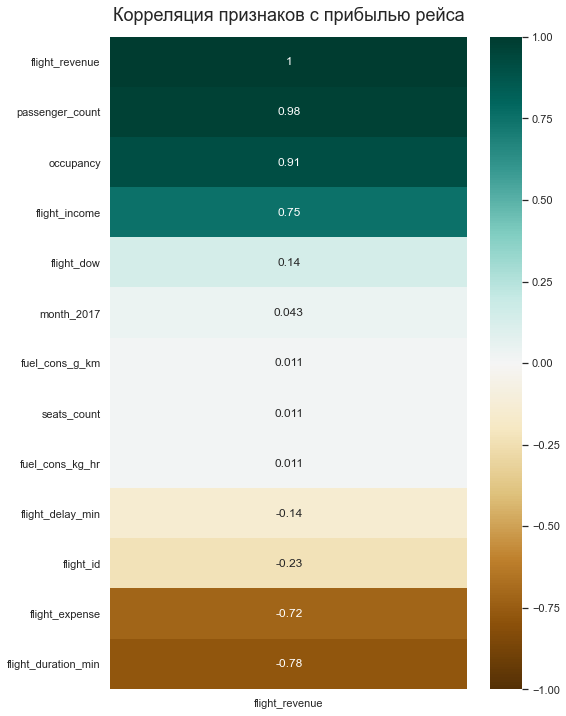

In [37]:
# Посмотрим, какие данные коррелируют с прибыльностью рейсов
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(flight.drop(['fuel_cost_dec_2016_rub_ton',
                                   'fuel_cost_jan_2017_rub_ton',
                                   'fuel_cost_feb_2017_rub_ton'], axis=1).corr()[['flight_revenue']].sort_values(
    by='flight_revenue', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляция признаков с прибылью рейса',
                  fontdict={'fontsize': 18}, pad=16)

**Прибыль по месяцам и рейсам за отчетный период**

Рисуем диаграмму, отображающую распределение прибыли в зависимости от направления за весь период.

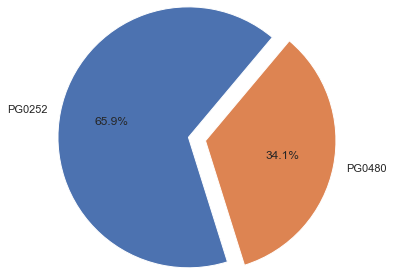

In [38]:
labels = list(flight[flight.flight_no != 'PG0194'].groupby(
    'flight_no')['flight_revenue'].sum().index)
sizes = flight[flight.flight_no != 'PG0194'].groupby('flight_no')[
    'flight_revenue'].sum()
explode = (0.1, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        startangle=50, radius=1.5)
plt.show()

Видим, что направление PG0252 приносит основную прибыль.

**Суммарная прибыль направлений по месяцам за период**

Рисуем диаграмму, отображающую распределение суммарной прибыли от направления в зависимости от номера рейса в каждый месяц зимнего периода.

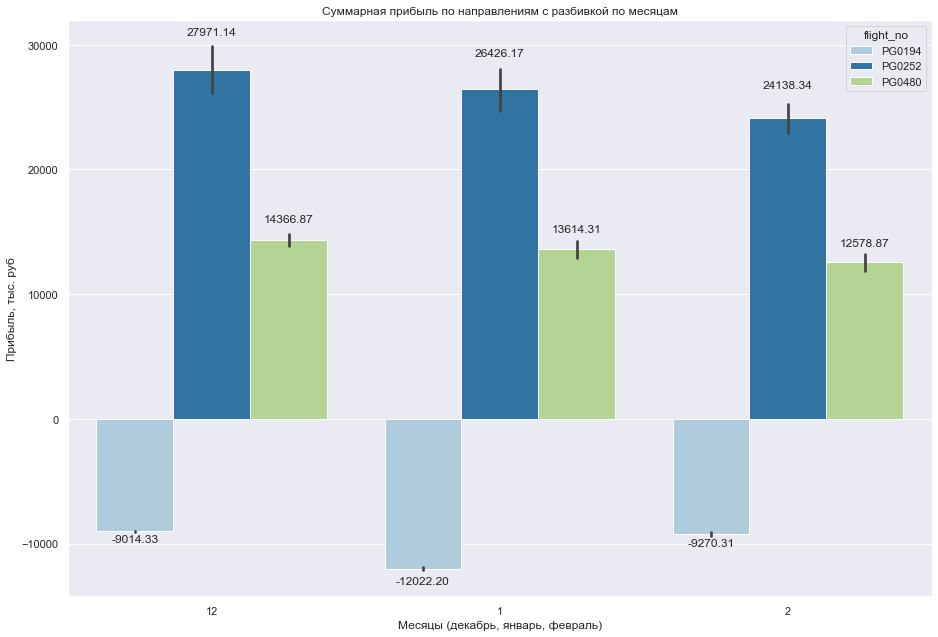

In [39]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x="month_2017", y="flight_revenue", hue="flight_no",
            data=flight, order=[12, 1, 2], palette="Paired", estimator=sum)
axes.set_xlabel('Месяцы (декабрь, январь, февраль)')
axes.set_ylabel('Прибыль, тыс. руб')
axes.set_title('Суммарная прибыль по направлениям с разбивкой по месяцам')
show_values_on_bars(axes)

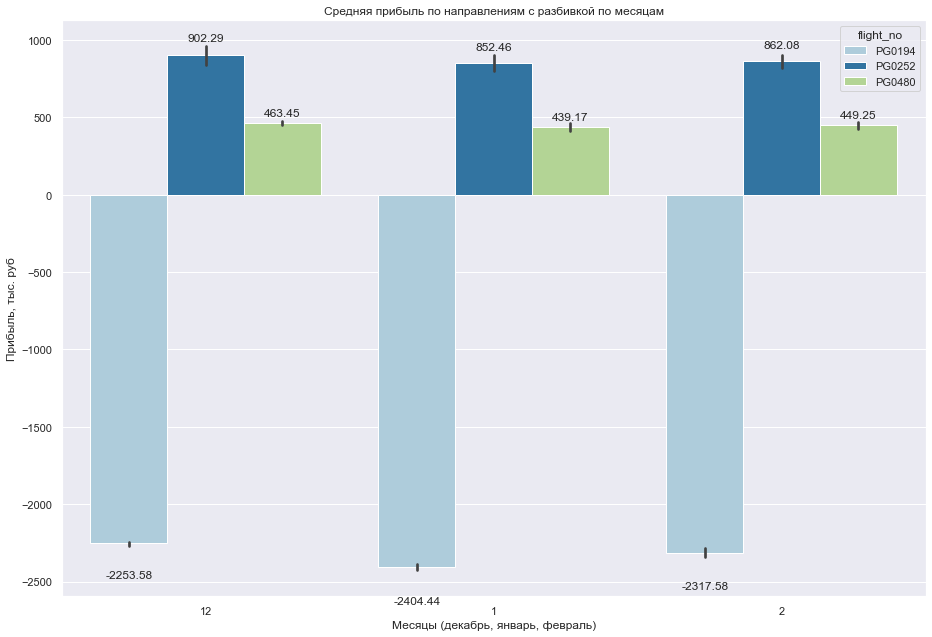

In [40]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x="month_2017", y="flight_revenue", hue="flight_no",
            data=flight, order=[12, 1, 2], palette="Paired")
axes.set_xlabel('Месяцы (декабрь, январь, февраль)')
axes.set_ylabel('Прибыль, тыс. руб')
axes.set_title('Средняя прибыль по направлениям с разбивкой по месяцам')
show_values_on_bars(axes)

*Выводы:*
- Нет значительной разницы в средней прибыли в разных месяцах, но суммарная прибыль слегка колеблется. 
- Отрицательное значение прибыли для рейса PG0194. Исключаем направление из дальнейшего анализа.

**Прибыль по рейсам и дням недели за зимний период**

Рисуем диаграмму, отображающую распределение прибыли в зависимости от номера рейса и дня недели, когда вылетает рейс.

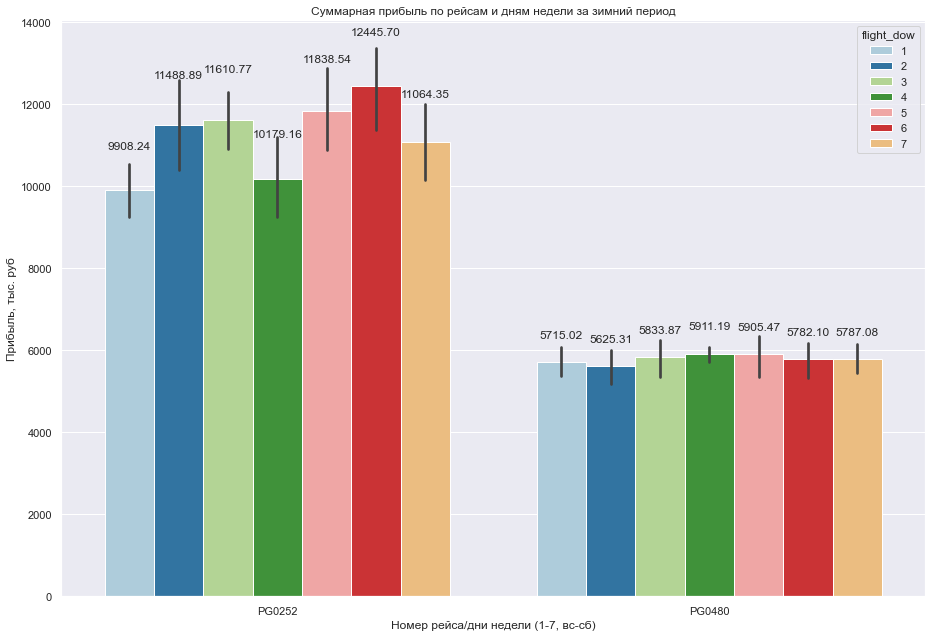

In [41]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x="flight_no", y="flight_revenue",
            hue="flight_dow", data=flight[flight.flight_no != 'PG0194'], palette="Paired", estimator=sum)
# Добавим поясняющие подписи
axes.set_xlabel('Номер рейса/дни недели (1-7, вс-сб)')
axes.set_ylabel('Прибыль, тыс. руб')
axes.set_title('Суммарная прибыль по рейсам и дням недели за зимний период')
show_values_on_bars(axes)

*Выводы:*
1. Рейс PG0480:
    - Осуществляет перелеты каждый день недели. 
    - Распределение прибыли достаточно равномерно по всем дням недели. Есть незначительный пик по средам (4). 
    - Визуально не проглядываются рейсы и дни недели, которые можно рекомендовать к сокращению.
2. Рейс PG0252:
    - Осуществляет перелеты каждый день недели. 
    - Наблюдаются колебания прибыли в зависимости от дня недели.
    - С учетом выбранной модели расчета прибыли, данные рейсы выглядят финансово прибыльными по сравнению с остальными (может измениться в случае изменения модели расчета прибыли). 
    - Дополнительно проанализировать рейсы, вылетающие в вс (1) и ср (4).

**Прибыль по рейсам за зимний период**

Рисуем диаграмму, отображающую распределение прибыли в зависимости от номера рейса.

Text(0.5, 1.0, 'Распределение прибыли по всем рейсам')

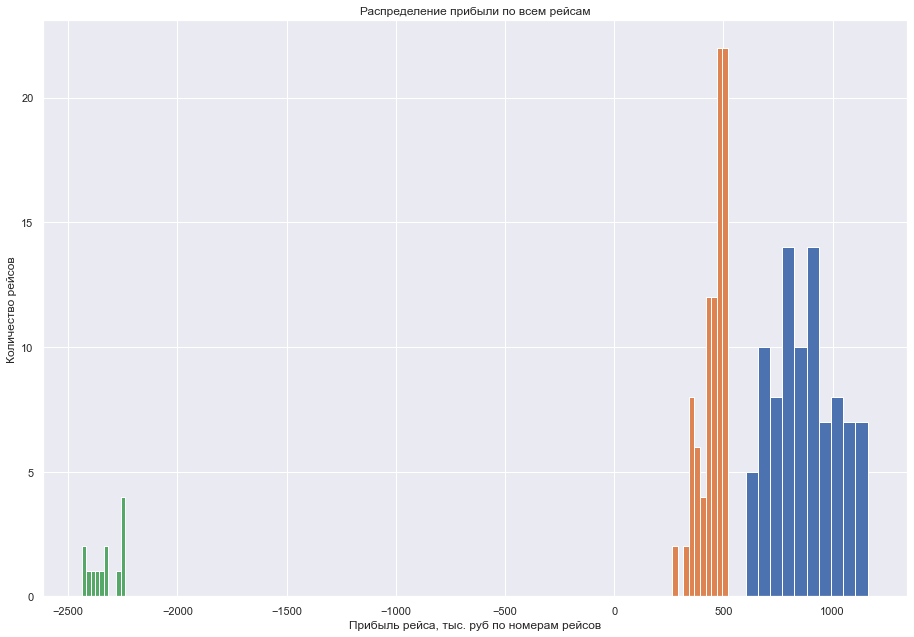

In [42]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
for x in (flight['flight_no'].value_counts())[0:3].index:
    flight['flight_revenue'][flight['flight_no'] == x].hist()
axes.set_xlabel('Прибыль рейса, тыс. руб по номерам рейсов')
axes.set_ylabel('Количество рейсов')
axes.set_title('Распределение прибыли по всем рейсам')

Исключим из диаграмы рейсы, которые точно невыгодные, посмотрим пристальнее на оставшиеся данные.

Распределение прибыли для PG0252 и PG0480 направлений


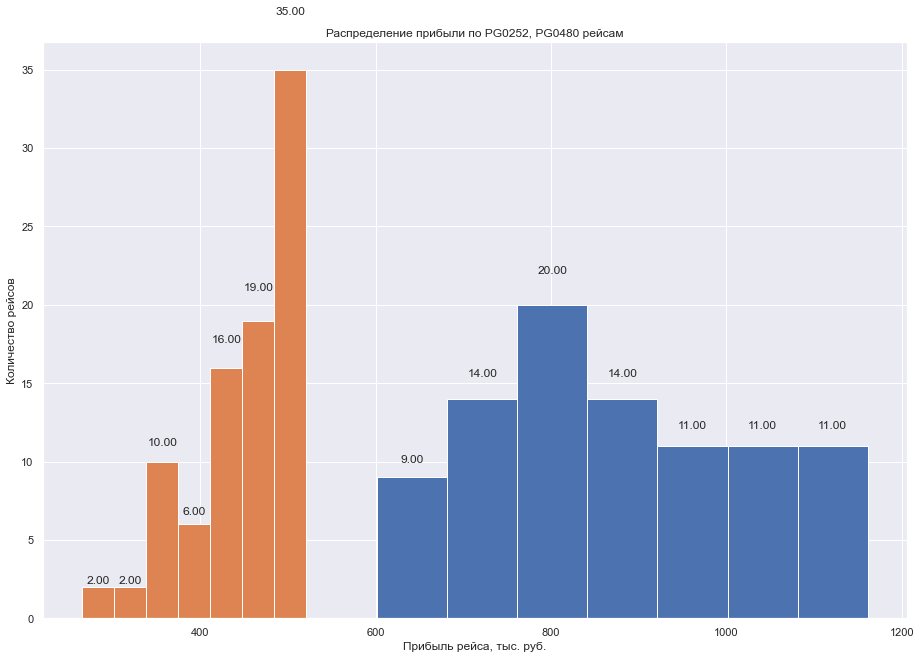

In [43]:
print('Распределение прибыли для PG0252 и PG0480 направлений')
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
for x in ['PG0252', 'PG0480']:
    flight['flight_revenue'][flight['flight_no'] == x].hist(bins=7)
axes.set_xlabel('Прибыль рейса, тыс. руб.')
axes.set_ylabel('Количество рейсов')
axes.set_title('Распределение прибыли по PG0252, PG0480 рейсам')
show_values_on_bars(axes)

*Вывод: как и на графиках выше, видно, что рейс PG0252 имеет нормальное распределение прибыли. 
Рейс же PG0480 имеет смещение. При этом есть кластеры перелетов, по которым прибыль значительно ниже.*

**Анализируем рейс PG0252.**

In [44]:
# Для удобства дальнейшего анализа создадим дф с частью колонок по конркетному рейсу
flight_0252 = flight[flight.flight_no == 'PG0252'][['flight_id', 'flight_no',
                                                    'month_2017', 'flight_dow', 'flight_duration_min',
                                                    'flight_delay_min', 'seats_count',
                                                    'passenger_count', 'occupancy', 'flight_income',
                                                    'flight_expense', 'flight_revenue']].copy()

In [45]:
# Посмотрим на данные датасета
flight_0252.describe()

,flight_id,month_2017,flight_dow,flight_duration_min,flight_delay_min,seats_count,passenger_count,occupancy,flight_income,flight_expense,flight_revenue
count,90.00000,90.000000,90.000000,90.0,90.000000,90.0,90.000000,90.000000,90.000000,90.000000,90.000000
mean,136307.80000,5.100000,4.000000,100.0,2.833391,130.0,113.444444,0.872650,1646.897778,774.279484,872.618293
std,112.22081,5.045968,2.022347,0.0,2.023855,0.0,9.910964,0.076238,143.771274,25.785423,148.582125
min,136119.00000,1.000000,1.000000,100.0,-1.000000,130.0,92.000000,0.707692,1372.400000,724.954043,601.727391
25%,136211.25000,1.000000,2.000000,100.0,1.250000,130.0,106.250000,0.817308,1543.500000,753.051377,762.306471
50%,136308.00000,2.000000,4.000000,100.0,3.000000,130.0,112.500000,0.865385,1635.300000,767.557493,855.336964
75%,136401.50000,12.000000,6.000000,100.0,4.000000,130.0,120.750000,0.928846,1760.050000,796.272609,978.619174
max,136492.00000,12.000000,7.000000,100.0,8.000000,130.0,130.000000,1.000000,1886.000000,835.346028,1161.045957


Text(0.5, 1.0, 'Распределение средней прибыли PG0252 рейса по дням недели и сравнение со средней прибылью рейса (красная черта)')

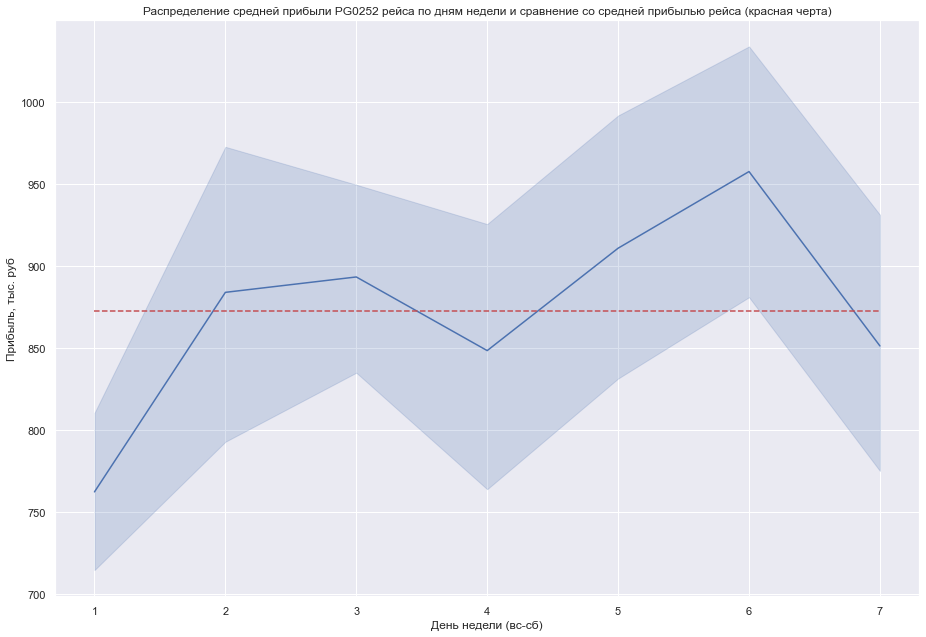

In [46]:
# Посмотрим на распределение полетов по дням недели в сравнении со средней прибылью по всем рейсам данного направления
mean = flight_0252['flight_revenue'].mean()
x = flight_0252.flight_dow.unique()
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.lineplot(data=flight_0252, x="flight_dow", y="flight_revenue")
axes.plot(x, [mean for i in x], '--', color='r')
# Добавим поясняющие подписи
axes.set_xlabel('День недели (вс-сб)')
axes.set_ylabel('Прибыль, тыс. руб')
axes.set_title(
    'Распределение средней прибыли PG0252 рейса по дням недели и сравнение со средней прибылью рейса (красная черта)')

*Вывод: предлагаю отказаться от рейсов по воскресеньям (1). Возможно, отказаться от части рейсов по средам (чт). Изучим, какие это рейсы и от какого пассажирообота отказываемся.*

<AxesSubplot:>

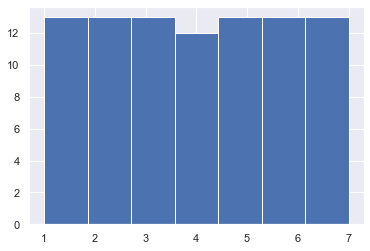

In [47]:
# Посмотрим на кол-во рейсов по дням недели
flight_0252.flight_dow.hist(bins=7)

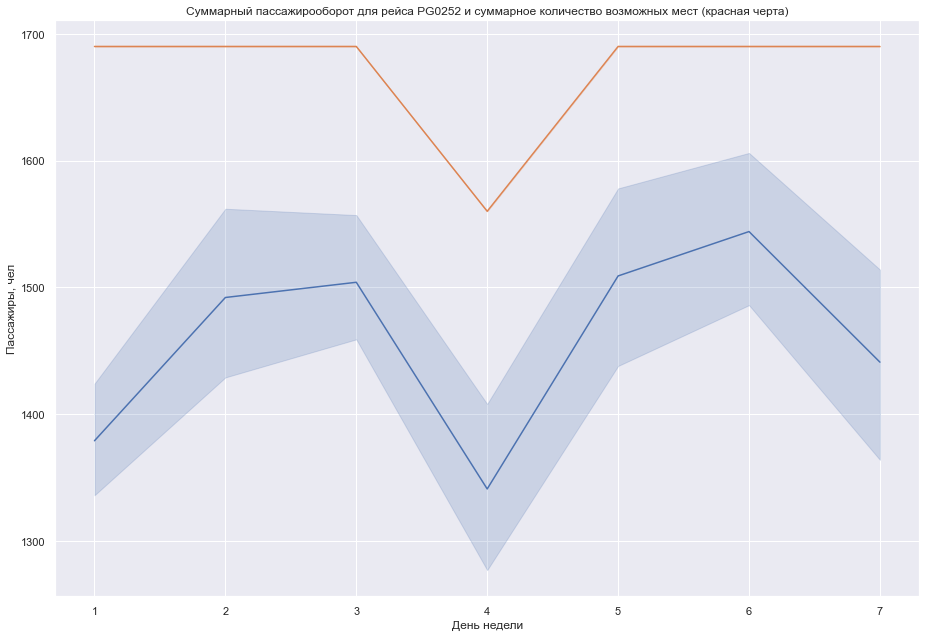

In [48]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
# axes.set_ylim(0,150)
sns.lineplot(data=flight_0252, x="flight_dow",
             y="passenger_count", estimator=sum)
sns.lineplot(data=flight_0252, x="flight_dow", y="seats_count", estimator=sum)
# Добавим поясняющие подписи
axes.set_xlabel('День недели')
axes.set_ylabel('Пассажиры, чел')
axes.set_title(
    'Суммарный пассажирооборот для рейса PG0252 и суммарное количество возможных мест (красная черта)')
show_values_on_bars(axes)

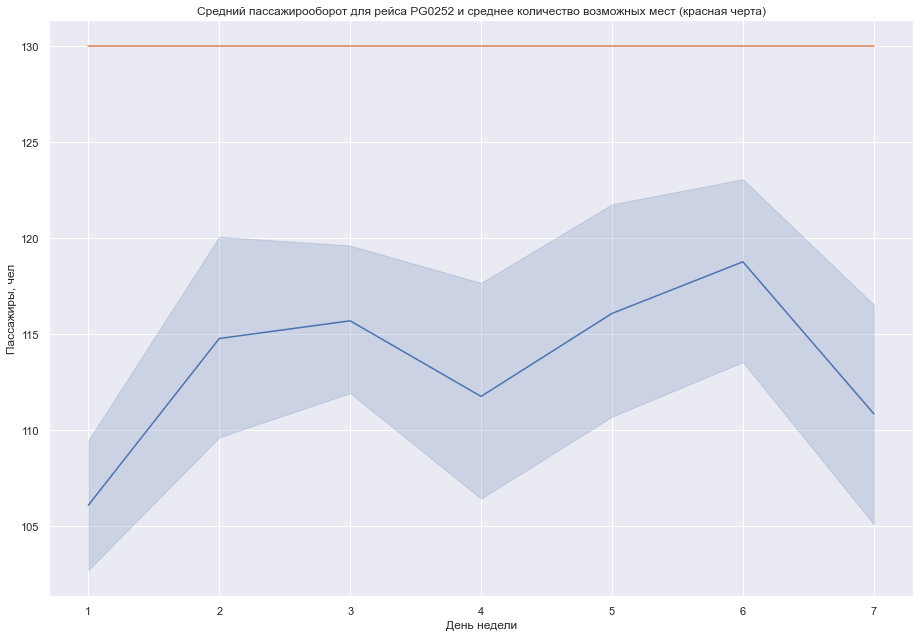

In [49]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
# axes.set_ylim(0,150)
sns.lineplot(data=flight_0252, x="flight_dow", y="passenger_count")
sns.lineplot(data=flight_0252, x="flight_dow", y="seats_count")
# Добавим поясняющие подписи
axes.set_xlabel('День недели')
axes.set_ylabel('Пассажиры, чел')
axes.set_title(
    'Средний пассажирооборот для рейса PG0252 и среднее количество возможных мест (красная черта)')
show_values_on_bars(axes)

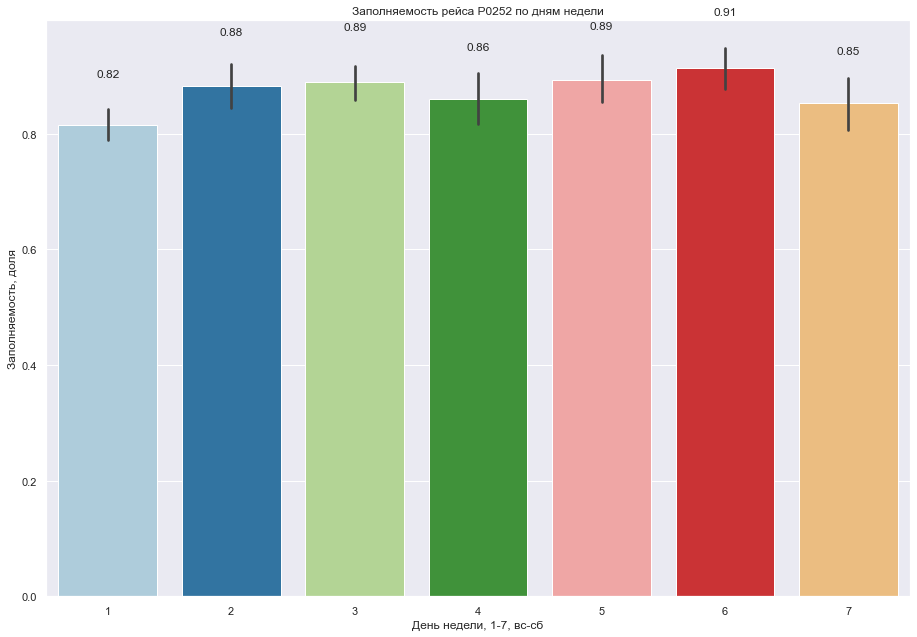

In [50]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x="flight_dow", y="occupancy", data=flight_0252, palette="Paired")
# Добавим поясняющие подписи
axes.set_xlabel('День недели, 1-7, вс-сб')
axes.set_ylabel('Заполняемость, доля')
axes.set_title('Заполняемость рейса P0252 по дням недели')
show_values_on_bars(axes)

*Выводы:*
- Поскольку корреляция с пассажирообортом и приболью очень высокая, то, закономерно, что рейс по вс имеею самую плохую заполняемость
- В базе данных за среду содержится меньшее количество рейсов по отношению к остальным дням недели
- Поскольку рейс по вс всё же прибыльный, можно попробовать рассчитать, будет ли достаточно остальных рейсов, чтобы удовлетворить спрос на данное направление.

In [51]:
# Посмотрим на ID рейссов, которые летали по вс
quantile = flight_0252.flight_revenue.quantile(q=0.05)
flight_0480_kill_1 = flight_0252[flight_0252.flight_dow == 1].sort_values(
    by='flight_revenue', ascending=True)
flight_0480_kill_1

,flight_id,flight_no,month_2017,flight_dow,flight_duration_min,flight_delay_min,seats_count,passenger_count,occupancy,flight_income,flight_expense,flight_revenue
14,136178,PG0252,1.0,1,100.0,4.0,130,99.0,0.761538,1434.6,811.885797,622.714203
13,136122,PG0252,1.0,1,100.0,3.0,130,97.0,0.746154,1431.0,804.079203,626.920797
15,136306,PG0252,12.0,1,100.0,5.0,130,102.0,0.784615,1443.2,768.890652,674.309348
17,136360,PG0252,2.0,1,100.0,3.0,130,97.0,0.746154,1455.4,767.557493,687.842507
16,136397,PG0252,12.0,1,100.0,2.0,130,104.0,0.800000,1444.4,746.922348,697.477652
18,136420,PG0252,1.0,1,100.0,2.0,130,104.0,0.800000,1542.0,796.272609,745.727391
20,136351,PG0252,2.0,1,100.0,8.0,130,105.0,0.807692,1555.4,804.817565,750.582435
19,136320,PG0252,2.0,1,100.0,0.0,130,106.0,0.815385,1544.4,745.201449,799.198551
23,136270,PG0252,2.0,1,100.0,6.0,130,111.0,0.853846,1628.6,789.913536,838.686464
21,136172,PG0252,1.0,1,100.0,-1.0,130,110.0,0.846154,1617.6,772.852826,844.747174


In [52]:
# Добавим id рейсов в flight_list0
flight_list0 = flight_0480_kill_1.flight_id.values
flight_list0

array([136178, 136122, 136306, 136360, 136397, 136420, 136351, 136320,
       136270, 136172, 136310, 136257, 136447])

In [53]:
print("Количетсво пассажиров, которые летали по вс за отчетный период:",
      flight_0252[flight_0252.flight_dow == 1].passenger_count.sum())
print("Количество пассажиро-мест, которые не заполнены по отсальным дням вылета:",
      flight_0252[flight_0252.flight_dow != 1].seats_count.sum()
      - flight_0252[flight_0252.flight_dow != 1].passenger_count.sum() + 130)
# Добавила 130, т.к. в один из дней неделей данных по рейсам на 1 меньше
print("Количество пассажиро-мест, спрос на которые не смогут удовлетворить при отмене рейса в Вс:",
      (flight_0252[flight_0252.flight_dow != 1].seats_count.sum()
       - flight_0252[flight_0252.flight_dow != 1].passenger_count.sum() + 130) -
      flight_0252[flight_0252.flight_dow == 1].passenger_count.sum())

Количетсво пассажиров, которые летали по вс за отчетный период: 1379.0
Количество пассажиро-мест, которые не заполнены по отсальным дням вылета: 1309.0
Количество пассажиро-мест, спрос на которые не смогут удовлетворить при отмене рейса в Вс: -70.0


Таким образом, если отменяются перелеты по вс, то заполняемость рейсов в течение недели будет близка к 100%, но спрос на перелеты будет не полностью удовлетворен => недополучение авиакомпанией части прибыли. Как вариант, можно пускать только один самолет в месяц по Вс.

Также стоит учитывать расходы, которые несет компания, помимо топлива, которые останутся даже в случае, если самолет не будет выполнять пассажирские перевозки.

In [54]:
# Посмотрим на 5% самых малоприбыльных рейсов
quantile = flight_0252.flight_revenue.quantile(q=0.05)
flight_0480_kill = flight_0252[flight_0252.flight_revenue < quantile].sort_values(
    by='flight_revenue', ascending=True)
flight_0480_kill

,flight_id,flight_no,month_2017,flight_dow,flight_duration_min,flight_delay_min,seats_count,passenger_count,occupancy,flight_income,flight_expense,flight_revenue
26,136464,PG0252,1.0,2,100.0,2.0,130,100.0,0.769231,1398.0,796.272609,601.727391
90,136352,PG0252,12.0,7,100.0,5.0,130,92.0,0.707692,1372.4,768.890652,603.509348
14,136178,PG0252,1.0,1,100.0,4.0,130,99.0,0.761538,1434.6,811.885797,622.714203
13,136122,PG0252,1.0,1,100.0,3.0,130,97.0,0.746154,1431.0,804.079203,626.920797
52,136250,PG0252,2.0,4,100.0,2.0,130,99.0,0.761538,1407.8,760.105478,647.694522


In [55]:
# Добавим в список
flight_list = flight_0480_kill.flight_id.values
flight_list

array([136464, 136352, 136178, 136122, 136250])

**Анализируем рейс PG0480.**

In [56]:
# Для удобства дальнейшего анализа создадим дф с частью колонок
flight_0480 = flight[flight.flight_no == 'PG0480'][['flight_id', 'flight_no',
                                                    'month_2017', 'flight_dow', 'flight_duration_min',
                                                    'flight_delay_min', 'seats_count',
                                                    'passenger_count', 'occupancy', 'flight_income',
                                                    'flight_expense', 'flight_revenue']].copy()

In [57]:
# Посмотрим на данные датасета
flight_0480.describe()

,flight_id,month_2017,flight_dow,flight_duration_min,flight_delay_min,seats_count,passenger_count,occupancy,flight_income,flight_expense,flight_revenue
count,90.000000,90.000000,90.000000,90.0,90.000000,90.0,90.000000,90.000000,90.000000,90.000000,90.000000
mean,136773.788889,5.100000,4.000000,50.0,3.155728,97.0,90.455556,0.932532,712.396667,261.729480,450.667187
std,108.313060,5.045968,2.022347,0.0,2.049779,0.0,7.276499,0.075015,58.773719,13.069052,59.955963
min,136571.000000,1.000000,1.000000,50.0,-1.000000,97.0,64.000000,0.659794,531.000000,234.610225,265.575797
25%,136678.500000,1.000000,2.000000,50.0,2.000000,97.0,87.000000,0.896907,677.100000,253.368493,419.320408
50%,136776.000000,2.000000,4.000000,50.0,3.000000,97.0,94.000000,0.969072,736.950000,259.434967,468.669152
75%,136865.750000,12.000000,6.000000,50.0,4.000000,97.0,96.750000,0.997423,763.725000,270.528514,494.472563
max,136961.000000,12.000000,7.000000,50.0,9.000000,97.0,97.000000,1.000000,765.300000,290.972208,521.113848


Text(0.5, 1.0, 'Распределение средней прибыли PG0480 рейса по дням недели и сравнение со средней прибылью рейса (красная черта)')

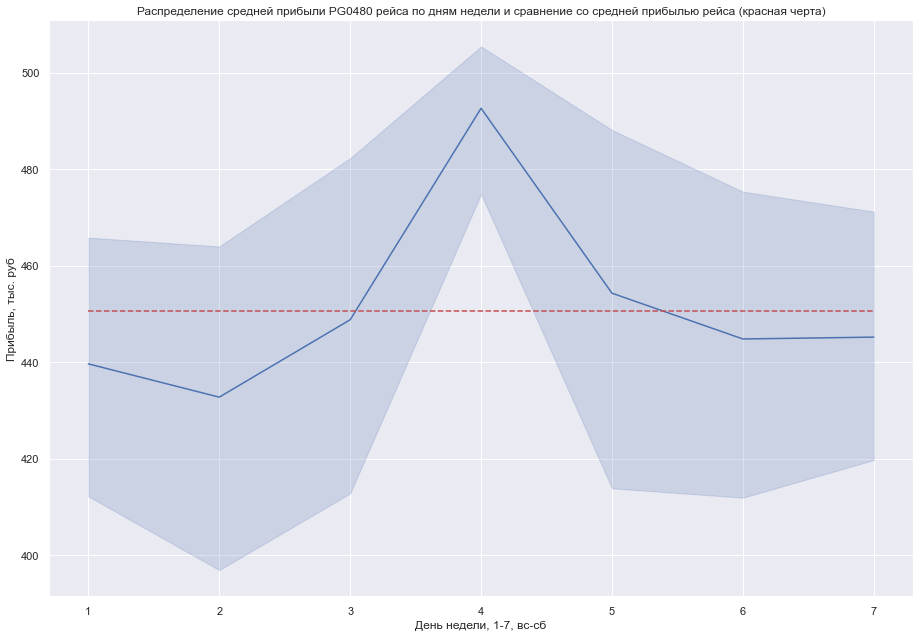

In [58]:
# Посмотрим на распределение полетов по дням недели в сравнении со средней прибылью по всем рейсам данного направления
mean = flight_0480['flight_revenue'].mean()
x = flight_0480.flight_dow.unique()
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.lineplot(data=flight_0480, x="flight_dow", y="flight_revenue")
axes.plot(x, [mean for i in x], '--', color='r')
# Добавим поясняющие подписи
axes.set_xlabel('День недели, 1-7, вс-сб')
axes.set_ylabel('Прибыль, тыс. руб')
axes.set_title(
    'Распределение средней прибыли PG0480 рейса по дням недели и сравнение со средней прибылью рейса (красная черта)')

*Вывод: распределение нормально. Самый прибыльный день - среда (4).

<AxesSubplot:>

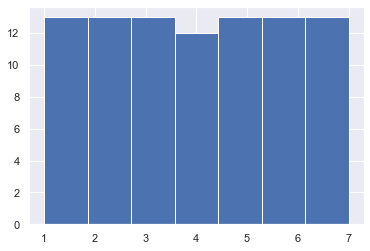

In [59]:
# Посмотрим на колиечество перелетов по дням недели в базе
flight_0480.flight_dow.hist(bins=7)

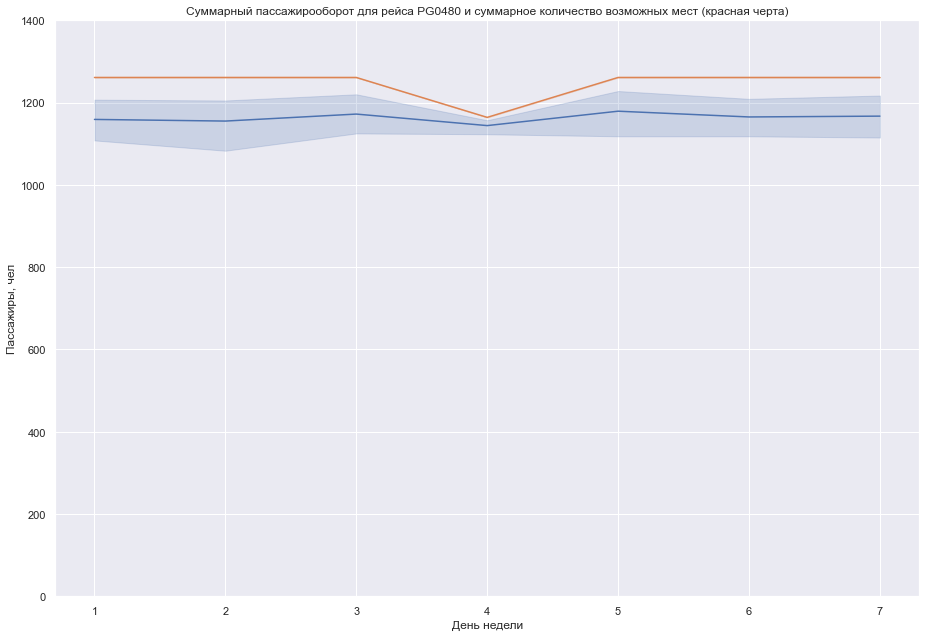

In [60]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
axes.set_ylim(0, 1400)
sns.lineplot(data=flight_0480, x="flight_dow",
             y="passenger_count", estimator=sum)
sns.lineplot(data=flight_0480, x="flight_dow", y="seats_count", estimator=sum)
# Добавим поясняющие подписи
axes.set_xlabel('День недели')
axes.set_ylabel('Пассажиры, чел')
axes.set_title(
    'Суммарный пассажирооборот для рейса PG0480 и суммарное количество возможных мест (красная черта)')
show_values_on_bars(axes)

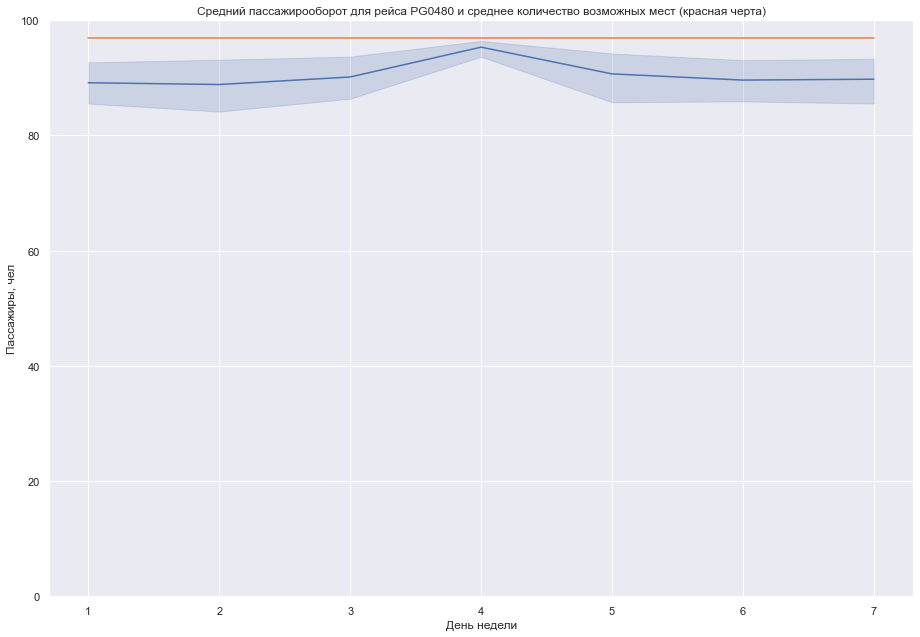

In [61]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
axes.set_ylim(0, 100)
sns.lineplot(data=flight_0480, x="flight_dow", y="passenger_count")
sns.lineplot(data=flight_0480, x="flight_dow", y="seats_count")
# Добавим поясняющие подписи
axes.set_xlabel('День недели')
axes.set_ylabel('Пассажиры, чел')
axes.set_title(
    'Средний пассажирооборот для рейса PG0480 и среднее количество возможных мест (красная черта)')
show_values_on_bars(axes)

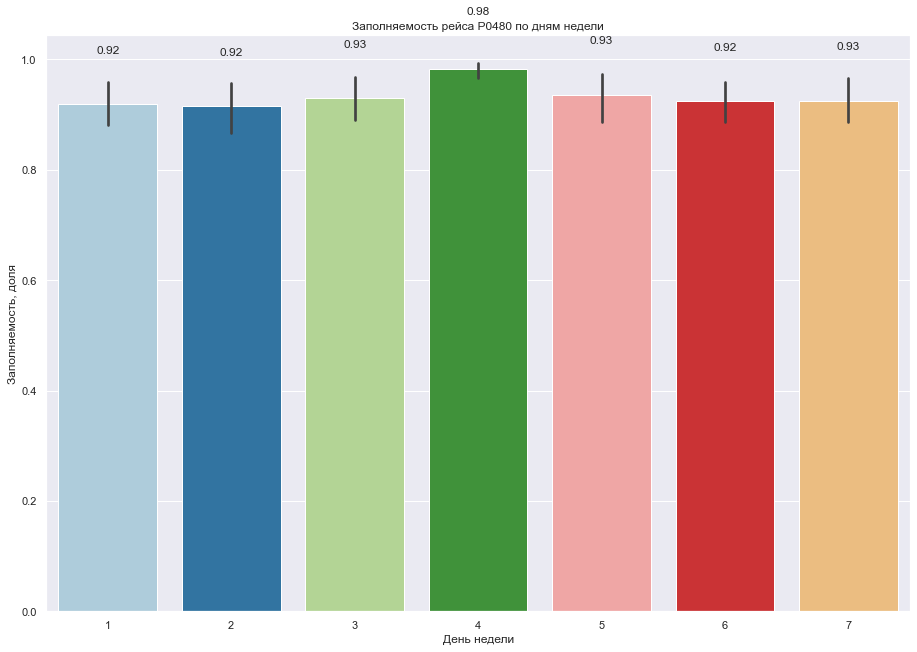

In [62]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x="flight_dow", y="occupancy", data=flight_0480, palette="Paired")
# Добавим поясняющие подписи
axes.set_xlabel('День недели')
axes.set_ylabel('Заполняемость, доля')
axes.set_title('Заполняемость рейса P0480 по дням недели')
show_values_on_bars(axes)

*Выводы:*
- Заполняемость рейсов почти полная, лучшая заполняемость по средам.

In [63]:
# Посмотрим на 3% самых малоприбыльных рейсов
quantile = flight_0480.flight_revenue.quantile(q=0.03)
flight_0480_kill = flight_0480[flight_0480.flight_revenue < quantile].sort_values(
    by='flight_revenue', ascending=True)
flight_0480_kill

,flight_id,flight_no,month_2017,flight_dow,flight_duration_min,flight_delay_min,seats_count,passenger_count,occupancy,flight_income,flight_expense,flight_revenue
116,136642,PG0480,1.0,2,50.0,2.0,97,64.0,0.659794,531.0,265.424203,265.575797
154,136807,PG0480,2.0,5,50.0,3.0,97,68.0,0.701031,531.0,258.240964,272.759036
167,136887,PG0480,1.0,6,50.0,4.0,97,78.0,0.804124,595.2,275.632826,319.567174


In [64]:
# Добавим id рейсов в flight_list2
flight_list2 = flight_0480_kill.flight_id.values
flight_list2

array([136642, 136807, 136887])

<a id="4"></a>

# 4. SUMMARY


1. **Общая информация о датасете для анализа:**
    
    - Номер рейса: PG0194
    
    - Совершает рейсы из аэропорта 'AAQ' (Анапа) в аэропорт 'NOZ' (Новокузнецк)
    
    - Совершенных рейсов: 13
    
    - Время вылета: '06:10', по дням недели: 3
    
    - Модель самолета: 'Boeing 737-300'

    - Количество перевезенных пассажиров, чел: 0.0
    
    - Средняя заполняемость рейсов, %: 0

    - Среднее время полета, мин: 305.0
    - Среднее время задержек прилета, мин: 4.15

    - Доход за отчетный период, тыс. руб: 0.0

    *********************************************

    - Номер рейса: PG0252
    - Совершает рейсы из аэропорта 'AAQ' (Анапа) в аэропорт 'SVO' (Москва)
    - Совершенных рейсов: 90
    - Время вылета: '10:05', по дням недели: 1 2 3 4 5 6 7
    - Модель самолета: 'Boeing 737-300'

    - Количество перевезенных пассажиров, чел: 10210.0
    - Средняя заполняемость рейсов, %: 87

    - Среднее время полета, мин: 100.0
    - Среднее время задержек прилета, мин: 5.06

    - Доход за отчетный период, тыс. руб: 148220.8

    *********************************************

    - Номер рейса: PG0480
    - Совершает рейсы из аэропорта 'AAQ' (Анапа) в аэропорт 'EGO' (Белгород)
    - Совершенных рейсов: 90
    - Время вылета: '09:25', по дням недели: 1 2 3 4 5 6 7
    - Модель самолета: 'Sukhoi Superjet-100'

    - Количество перевезенных пассажиров, чел: 8141.0
    - Средняя заполняемость рейсов, %: 93

    - Среднее время полета, мин: 50.0
    - Среднее время задержек прилета, мин: 9.37

    - Доход за отчетный период, тыс. руб: 64115.7

    *********************************************
2. **Выводы о самых малоприбыльных рейсах.**

    
1. Рейсы **PG0194** летают раз в неделю и являются убыточным, судя по данным из базы. 
      - Необходимо прояснение, какие перевозки осуществляются, т.к. отсутствует информация о заполняемости и доходах. 
      - Возможно, используется как грузовой/почтовый. 
      - Из дальнейшего анализа исключен.
    
2. Рейсы **PG0480 и PG0252** являются регулярными и осуществляют перевозки каждый день в течение неделю. Более 65% прибыли авиакомпании по данной выборке приносят рейсы PG0252.
       
Выявлены следующие возможные стратегии по оптимизации прибыли рейсов в зимнее время:
       
   - *Стратегия 1: пересмотр расписания для регулярных рейсов*.
      * Прибыль рейса PG0480 стабильна в течение недели.
      * Для рейса PG0252 можно попробовать отменить перелёты по  воскресеньям в зимний период. Воскресенье (Вс) выбран, т.к. 1) самая низкая суммарная прибыль 2)  95% всех рейсов Вс приносят в среднем меньше прибыли, чем средняя прибыль за рейс по направлению. ID таких рейсов: 136178, 136122, 136306, 136360, 136397, 136420, 136351, 136320, 136270, 136172, 136310, 136257, 136447.
        
     Ограничения такого подхода:
      * При отмене рейсов в Вс заполняемость рейсов в течение последующей недели будет близка к 100%, но даже при этом, спрос на перелеты будет удовлетворен не полностью (~70 пассажира-мест не будет обеспечен) => недополученные авиакомпанией части дохода. 
      * Необходим анализ расходов в случае простоя самолета.
      
   
   - *Стратегия 2: отмена самых малоприбыльных/не заполняемых рейсов на базе статистических данных за период*.
     
     Возможные варианты критериев для отмены рейсов:
      * «Отменить x% самых малоприбыльных рейсов»
      * «Отменить рейсы, прибыльность которых … а) ниже медианы прибыли b) ниже средней прибыли »
     
     Например:
      * 3% самых малоприбыльных рейсов PG0480 –  136642, 136807, 136887
      * 5% самых малоприбыльных рейсов PG0252 –  136464, 136352, 136178, 136122, 136250
     
     Ограничения: 
      * Рейс (как направление) становится нерегулярным, не выполняется по тем же дням недели в течение месяца. 
      * Принимаем решение об отмене на основании заполняемости рейса за один отчетный зимний период. Данных недостаточно для принятия таких решений.
              
3. Значительного колебания прибыли между месяцами (дек, янв, фев) выявлено не было.
   
4. Для расчетов была использована упрощенная модель формирования затрат на авиаперевозки. При добавлении более точных данных по расходам, выводы могут быть пересмотрены.